In [1]:
# Phase 1: Setup and Data Loading

# 1. Standard Library Imports
import re
import string

# 2. Data Handling and Machine Learning Libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
import joblib # For saving the model

# 3. Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

print("Libraries loaded successfully.")

# Load the dataset
# Assumes the file 'intent_dataset.csv' is uploaded to your Colab session.
try:
    df = pd.read_csv('intent_dataset.csv')
    print(f"\nDataset loaded. Shape: {df.shape}")
    print("\nFirst 5 rows:")
    print(df.head())
except FileNotFoundError:
    print("Error: 'intent_dataset.csv' not found. Please ensure the file is uploaded to your Colab environment.")

# Check for balance (requirement check)
intent_counts = df['Intent'].value_counts()
print("\nIntent Distribution:")
print(intent_counts)

# Check for the required intents
required_intents = ['email_send', 'calendar_schedule', 'web_search', 'knowledge_query', 'general_chat']
if all(intent in intent_counts.index for intent in required_intents):
    print("\nAll required intents found in the dataset.")
else:
    print("\nWarning: Some required intents are missing from the dataset.")

# Initialize the Utterances (X) and Intents (y)
X = df['Utterance']
y = df['Intent']

Libraries loaded successfully.

Dataset loaded. Shape: (1000, 2)

First 5 rows:
       Intent                                          Utterance
0  email_send  Send an email to John about the budget meeting...
1  email_send  Draft an email to Sarah asking for an update o...
2  email_send  Please email my manager that I'll be late tomo...
3  email_send  Can you send a quick email to Alex with the ne...
4  email_send  I need to email the sales team regarding the Q...

Intent Distribution:
Intent
email_send           200
calendar_schedule    200
web_search           200
knowledge_query      200
general_chat         200
Name: count, dtype: int64

All required intents found in the dataset.


In [2]:
# Phase 2: Data Preprocessing and Splitting

# --- 2.1 Text Cleaning and Normalization Function ---
def clean_text(text):
    """
    Performs basic text cleaning:
    1. Converts to lowercase.
    2. Removes punctuation.
    3. Removes numbers.
    4. Removes extra whitespace.
    """
    text = text.lower() # Convert to lowercase [cite: 1036]
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text) # Remove punctuation [cite: 1036]
    text = re.sub(r'\d+', '', text) # Remove digits
    text = text.strip() # Remove leading/trailing whitespace
    return text

# Apply the cleaning function to the Utterances
X_cleaned = X.apply(clean_text)

# --- 2.2 Label Encoding ---
# Convert categorical intent labels (strings) into numerical format
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
class_names = label_encoder.classes_

print(f"\nTotal classes: {len(class_names)}")
print(f"Class mapping: {dict(zip(range(len(class_names)), class_names))}")

# --- 2.3 80/10/10 Train/Validation/Test Split ---

# Step 1: Split 80% (Train) and 20% (Temp: Val + Test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X_cleaned, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Step 2: Split Temp (20%) into 10% (Validation) and 10% (Test)
# The split should be 0.5 of the remaining 20%
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# Display the resulting split sizes
print("\nData Split (80/10/10):")
print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/df.shape[0]:.0%})")
print(f"Validation set size: {X_val.shape[0]} ({X_val.shape[0]/df.shape[0]:.0%})")
print(f"Testing set size: {X_test.shape[0]} ({X_test.shape[0]/df.shape[0]:.0%})")


Total classes: 5
Class mapping: {0: 'calendar_schedule', 1: 'email_send', 2: 'general_chat', 3: 'knowledge_query', 4: 'web_search'}

Data Split (80/10/10):
Training set size: 800 (80%)
Validation set size: 100 (10%)
Testing set size: 100 (10%)


In [3]:
# Phase 3: Feature Engineering, Model Selection, and Training

# --- 3.1 Define the Pipeline (Feature Engineering + Model) ---

# TfidfVectorizer: Converts text into a matrix of TF-IDF features [cite: 1040]
# min_df=5: Ignores terms that appear in less than 5 documents (removes noise).
# ngram_range=(1, 2): Considers unigrams and bigrams (e.g., "send" and "send email").
tfidf = TfidfVectorizer(min_df=5, ngram_range=(1, 2), stop_words='english')

# LogisticRegression: A robust and lightweight classical classifier
model = LogisticRegression(max_iter=1000, random_state=42)

# Create the ML Pipeline
# A pipeline chains the vectorizer and the classifier, ensuring data consistency
pipeline = Pipeline([
    ('tfidf', tfidf),
    ('classifier', model)
])

print("\nML Pipeline created: TF-IDF -> Logistic Regression")

# --- 3.2 Model Training ---
print("Starting model training on the 80% training data...")
pipeline.fit(X_train, y_train)
print("Model training complete.")

# --- 3.3 Validate  ---
# Use the validation set for initial tuning or check
y_val_pred = pipeline.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Set Accuracy: {val_accuracy:.4f}")


ML Pipeline created: TF-IDF -> Logistic Regression
Starting model training on the 80% training data...
Model training complete.

Validation Set Accuracy: 0.8200



PHASE 4: HYPERPARAMETER TUNING AND CROSS-VALIDATION

Defined parameter grid for hyperparameter tuning.
Setup GridSearchCV with 5-fold cross-validation.

Starting hyperparameter tuning with cross-validation...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Hyperparameter tuning complete.

Best Cross-Validation Accuracy: 0.8600
Best Parameters: {'classifier__C': 10, 'classifier__solver': 'liblinear', 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 1)}

PHASE 5: COMPREHENSIVE EVALUATION AND MODEL SAVING

TEST SET CLASSIFICATION PERFORMANCE REPORT (10%)
Overall Accuracy: 0.9000

                   precision    recall  f1-score   support

calendar_schedule     0.9524    1.0000    0.9756        20
       email_send     1.0000    1.0000    1.0000        20
     general_chat     0.7917    0.9500    0.8636        20
  knowledge_query     0.9000    0.9000    0.9000        20
       web_search     0.8667    0.6500    0.7429        20

         accuracy                         0.9000

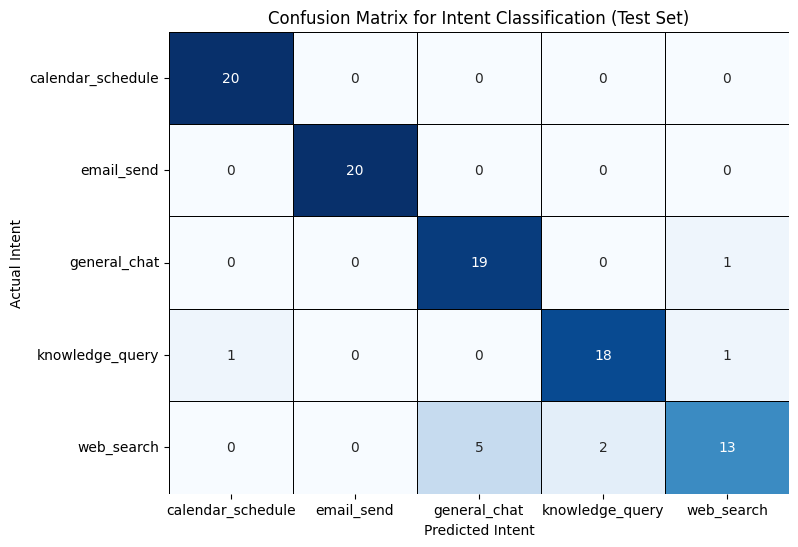


MODEL DEPLOYMENT READY ARTIFACTS SAVED
Trained Model Pipeline saved to: intent_classifier_pipeline.pkl
Label Encoder saved to: intent_label_encoder.pkl


In [4]:
# Phase 4: Hyperparameter Tuning and Cross-validation

print("\n" + "="*50)
print("PHASE 4: HYPERPARAMETER TUNING AND CROSS-VALIDATION")
print("="*50)

# --- 4.1 Define the Parameter Grid for Tuning ---
# We'll tune parameters for both TfidfVectorizer and LogisticRegression
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3)], # Test unigrams, bigrams, and trigrams
    'tfidf__min_df': [1, 3, 5], # Test different minimum document frequencies
    'classifier__C': [0.1, 1, 10], # Test different regularization strengths
    'classifier__solver': ['liblinear', 'lbfgs'] # Test different solvers
}

print("\nDefined parameter grid for hyperparameter tuning.")

# --- 4.2 Setup GridSearchCV with Cross-Validation ---
# GridSearchCV performs an exhaustive search over the specified parameter values.
# cv=5: Use 5-fold cross-validation [cite: 1046]
# scoring='accuracy': Evaluate models based on accuracy
# n_jobs=-1: Use all available CPU cores for parallel processing
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1 # Display progress
)

print("Setup GridSearchCV with 5-fold cross-validation.")

# --- 4.3 Perform Hyperparameter Tuning ---
print("\nStarting hyperparameter tuning with cross-validation...")
grid_search.fit(X_train, y_train)
print("Hyperparameter tuning complete.")

# --- 4.4 Get the Best Model and Parameters ---
best_pipeline = grid_search.best_estimator_
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"\nBest Cross-Validation Accuracy: {best_score:.4f}")
print(f"Best Parameters: {best_params}")

# Phase 5: Comprehensive Evaluation and Model Saving

print("\n" + "="*50)
print("PHASE 5: COMPREHENSIVE EVALUATION AND MODEL SAVING")
print("="*50)

# --- 5.1 Prediction on the Test Set using the Best Model ---
y_test_pred = best_pipeline.predict(X_test)

# To get the confidence score ,
# we use predict_proba for the probability of each class.
y_test_pred_proba = best_pipeline.predict_proba(X_test)
# The confidence for the predicted class is the maximum probability across classes
y_test_conf = y_test_pred_proba.max(axis=1)

# --- 5.2 Core Metrics Report ---
print("\n" + "="*50)
print("TEST SET CLASSIFICATION PERFORMANCE REPORT (10%)")
print("="*50)

# Accuracy
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Overall Accuracy: {test_accuracy:.4f}\n")

# Detailed Report (Precision, Recall, F1-score, Support)
print(classification_report(
    y_test,
    y_test_pred,
    target_names=class_names,
    digits=4,
    zero_division=0
))

# --- 5.3 Confusion Matrix Visualization ---
# Compute Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

# Plot
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_df,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    linewidths=0.5,
    linecolor='black'
)
plt.title('Confusion Matrix for Intent Classification (Test Set)')
plt.ylabel('Actual Intent')
plt.xlabel('Predicted Intent')
plt.show()

# --- 5.4 Model Saving
# Save the trained pipeline object and the LabelEncoder (to inverse transform predictions)
MODEL_PATH = 'intent_classifier_pipeline.pkl'
LABEL_ENCODER_PATH = 'intent_label_encoder.pkl'

joblib.dump(best_pipeline, MODEL_PATH) # Save the best pipeline
joblib.dump(label_encoder, LABEL_ENCODER_PATH)

print("\n" + "="*50)
print("MODEL DEPLOYMENT READY ARTIFACTS SAVED")
print(f"Trained Model Pipeline saved to: {MODEL_PATH}")
print(f"Label Encoder saved to: {LABEL_ENCODER_PATH}")
print("="*50)